In [1]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 24.33 MiB/s, done.


In [2]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Perform image augmentation

In [3]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=5,
                                   zoom_range=0.05, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.2)

train_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=image_size, 
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               subset='training')

valid_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=image_size, 
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               subset='validation')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

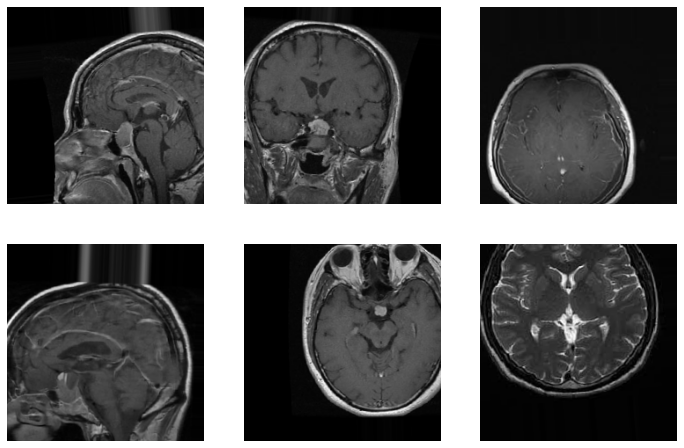

In [5]:
# View 6 samples of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

### Build our CNN model based on EfficientNetB1 model

In [6]:
EffNetB1 = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Rebuild top
model = EffNetB1.output
model = GlobalAveragePooling2D(name='avg_pool')(model)
model = Dropout(0.5, name='top_dropout')(model)
model = Dense(4, activation='softmax', name='predict')(model)

model = Model(inputs=EffNetB1.input, outputs=model, name='EfficientNet')

model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [8]:
train_history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - 85s 758ms/step - loss: 0.8294 - accuracy: 0.6735 - val_loss: 0.9392 - val_accuracy: 0.5812

Epoch 00001: val_accuracy improved from -inf to 0.58115, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
72/72 [==============================] - 52s 716ms/step - loss: 0.3300 - accuracy: 0.8829 - val_loss: 0.5988 - val_accuracy: 0.7644

Epoch 00002: val_accuracy improved from 0.58115 to 0.76440, saving model to model.h5
Epoch 3/10
72/72 [==============================] - 52s 717ms/step - loss: 0.2169 - accuracy: 0.9212 - val_loss: 0.4541 - val_accuracy: 0.8185

Epoch 00003: val_accuracy improved from 0.76440 to 0.81850, saving model to model.h5
Epoch 4/10
72/72 [==============================] - 52s 718ms/step - loss: 0.1428 - accuracy: 0.9539 - val_loss: 0.4821 - val_accuracy: 0.8185

Epoch 00004: val_accuracy did not improve from 0.81850
Epoch 5/10
72/72 [==============================] - 52s 717ms/step - loss: 0.0833 - accuracy: 0.9730 - val_loss: 0.4788 - val_accuracy: 0.8325

Epoch 00005: val_accuracy improved from 0.81850 to 0.83246, saving model to model.h5
Epoch 6/10
72/72 [==============================] - 52s 720ms/step - loss: 0.0629 - accuracy: 0.9804 - val_loss: 0

The train accuracy is 99.17% and the validation accuracy is 88.66%.  

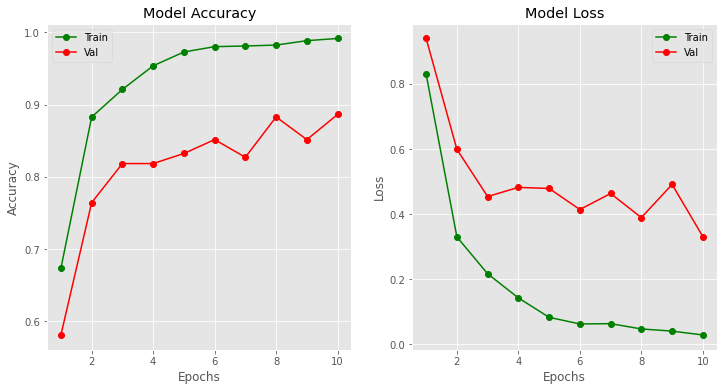

In [9]:
# Plot the training curves
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
epochs = range(1,11)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_history.history['accuracy'], 'go-')
plt.plot(epochs, train_history.history['val_accuracy'], 'ro-')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_history.history['loss'], 'go-')
plt.plot(epochs, train_history.history['val_loss'], 'ro-')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate model performance on the test dataset

In [10]:
test_datagen = ImageDataGenerator()
test_data = test_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Testing', 
                                             target_size=image_size, 
                                             class_mode='categorical')

Found 394 images belonging to 4 classes.


In [11]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 0.8270 - accuracy: 0.7995
Test accuracy is 79.95%


The test accuracy is 79.95%.  Comparing to the 71.83% test accuracy of my original model, there is a 11.3% improvement.

### Unfreeze top 30 layers of Efficient Net model

In [12]:
for layer in model.layers[-30:]:
  if not isinstance(layer, BatchNormalization):
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - 68s 757ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.2830 - val_accuracy: 0.9092

Epoch 00001: val_accuracy improved from 0.88656 to 0.90925, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
72/72 [==============================] - 52s 720ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.1947 - val_accuracy: 0.9389

Epoch 00002: val_accuracy improved from 0.90925 to 0.93892, saving model to model.h5
Epoch 3/10
72/72 [==============================] - 52s 717ms/step - loss: 0.0289 - accuracy: 0.9900 - val_loss: 0.2901 - val_accuracy: 0.9215

Epoch 00003: val_accuracy did not improve from 0.93892
Epoch 4/10
72/72 [==============================] - 52s 717ms/step - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.2204 - val_accuracy: 0.9442

Epoch 00004: val_accuracy improved from 0.93892 to 0.94415, saving model to model.h5
Epoch 5/10
72/72 [==============================] - 52s 716ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.1608 - val_accuracy: 0.9476

Epoch 00005: val_accuracy improved from 0.94415 to 0.94764, saving model to model.h5
Epoch 6/10
72/72 [==============================] - 52s 716ms/step - loss: 0.0121 - accuracy: 0.9952 - val_loss: 0

In [13]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 0.9366 - accuracy: 0.8299
Test accuracy is 82.99%


Unfreezing the top 30 layers helps to boost up the test accuracy from 79.95% to 82.99% which is about 3.8%.

### Model evaluation

In [14]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, np.argmax(y, axis=1)])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_labels[:10])

predictions =  [2. 2. 0. 2. 2. 0. 1. 2. 2. 1.]
True labels =  [2. 2. 0. 2. 2. 0. 1. 0. 2. 1.]


In [15]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 44  29  26   1]
 [  0 113   2   0]
 [  0   0 105   0]
 [  0   3   6  65]], shape=(4, 4), dtype=int32)


In [16]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.44      0.61       100
meningioma_tumor       0.78      0.98      0.87       115
        no_tumor       0.76      1.00      0.86       105
 pituitary_tumor       0.98      0.88      0.93        74

        accuracy                           0.83       394
       macro avg       0.88      0.83      0.82       394
    weighted avg       0.87      0.83      0.81       394



The recall rate of the glioma tumor class of the original model was very low.  We see that there is an improvement using the trannsfer learning technique.  The recall rate goes up from 0.18 to 0.44.  The meningioma tumor and no tumor classes also improved in precision and recall rates.  However, the recall rate of the pituitary tumor class goes down from 0.95 to 0.88.  